In this notebook, we summarized all the analysis which was performed on the 16,703 cells from patchseq, EM, ME and fMOST platforms.

In [1]:
# from python
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import mplcursors  # Import the mplcursors library
from scipy import stats
from sklearn.metrics import get_scorer


# from cplAE_MET
from cplAE_MET.utils.analysis_helpers import load_exp_output, Get_available_modalities_in_each_platform, calculate_and_plot_umap
from cplAE_MET.utils.optuna_helpers import load_study
from cplAE_MET.utils.plots import plot_z_3d, plot_m
from cplAE_MET.utils.utils import get_all_1d_mask
from cplAE_MET.models.classification_functions import get_kfold_stratified_acc_per_fold


from cplAE_MET.models.classification_functions import run_QDA

# from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from collections import Counter

# from optuna
from optuna.visualization import plot_parallel_coordinate
from cplAE_MET.utils.analysis_tree_helpers import HTree, get_merged_types

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool'}


All the input data are stored in the following path:

dat = "/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Patchseq-Exc/dat"

The input mat file for the 16,703 cells is called: "MET_M120x1_16k_28June23.mat"

## 1. Data overview in each platform:

In [2]:
mat = sio.loadmat("/home/fahimehb/Remote-AI-root/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Patchseq-Exc/dat/MET_M120x1_16k_28June23.mat")
print("shape of t data:", mat['T_dat'].shape)
print("shape of e data:", mat['E_dat'].shape)
print("shape of m data:", mat['M_dat'].shape)

shape of t data: (16703, 1252)
shape of e data: (16703, 82)
shape of m data: (16703, 120, 1, 4)


In [3]:
# print the partition of the modalities(t, e, m) in each platfrom(patchseq, ME, EM, fmost)
# MET_M120x1_16k_28June23.mat: This is the input of 16k cells with 120x1 shape of m data. 
# all the patchseq, ME, fmost cells are included. 7900 EM cells were also included based on their distance from patchseq cells
(
    number_of_patchseq_tem, number_of_patchseq_teonly, number_of_patchseq_tmonly,
    number_of_patchseq_meonly, number_of_patchseq_tonly, number_of_patchseq_eonly,
    number_of_patchseq_monly,
    number_of_ME_monly, number_of_ME_eonly, number_of_ME_meonly,
    number_of_EM_cells, number_of_fmost_cells
) = Get_available_modalities_in_each_platform("MET_M120x1_16k_28June23.mat")

cells with t data available 6552
cells with e data available 7733
cells with m data available 10246
cells with te data available 5778
cells with me data available 1887
cells with tm data available 1557
cells with tem data available 1394
patchseq cells: 6614
patchseq cells with all t,e,m: 1394
patchseq cells with only t,e: 4384
patchseq cells with only t,m: 163
patchseq cells with only m,e: 57
patchseq cells with only t: 611
patchseq cells with only e: 0
patchseq cells with only m: 5
ME cells: 1909
ME cells with only m: 11
ME cells with only e: 1462
ME cells with both e, m: 436
total number of cells: 16703
check number of t cells: True
check number of e cells: True
check number of m cells: True
Note that all EM and fMOST cells are m only cells
Number of EM cells: 7900
Number of fMOST cells: 280


### 1.2 Plot data partitions

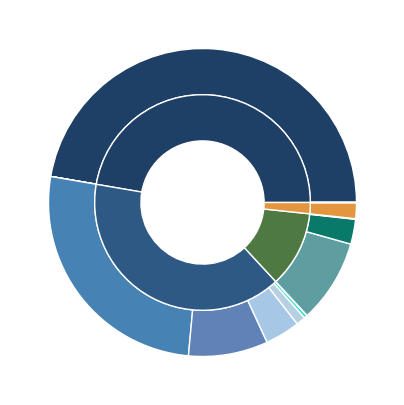

In [4]:
# I will put the labels in powerpoint

fig, ax = plt.subplots(figsize=(5,5))
size = 0.3
vals = np.array([[number_of_EM_cells, 0, 0, 0, 0, 0], # EM cell partitions
                 [number_of_patchseq_teonly, number_of_patchseq_tem, number_of_patchseq_tonly, number_of_patchseq_tmonly, number_of_patchseq_meonly, number_of_patchseq_monly],  # patchseq cells partitions
                 [number_of_ME_eonly, number_of_ME_meonly, number_of_ME_monly ,0, 0, 0], # ME cells partitions
                 [number_of_fmost_cells, 0, 0, 0, 0, 0]]) # fmost cells partiotions

inner_colors = ["#1E3F66", "#2E5984", "#4F7942", "#E3963E"]
outer_colors = ["#1E3F66", "#1E3F66", "#1E3F66", "#1E3F66", "#1E3F66", "#1E3F66", # EM colors
                "#4682B4", "#6082B6", "#A7C7E7", "#B6D0E2", "#40E0D0", "#40E0D0", # patchseq colors
                "#5F9EA0", "#097969", "#7CFC00", "#7CFC00", "#7CFC00", "#7CFC00", # ME colors
                "#E3963E", "#E3963E", "#E3963E", "#E3963E", "#E3963E", "#E3963E"] # fmost colors

ax.pie(vals.flatten(), radius=1, colors=outer_colors, wedgeprops=dict(width=size, edgecolor='w')) 
ax.pie(vals.sum(axis=1), radius=1-size, colors=inner_colors, wedgeprops=dict(width=size, edgecolor='w'))

plt.show()
fig.savefig("/home/fahimehb/Local/new_codes/cplAE_MET/data/results/Figure/manuscript_figure_pieplot.pdf")

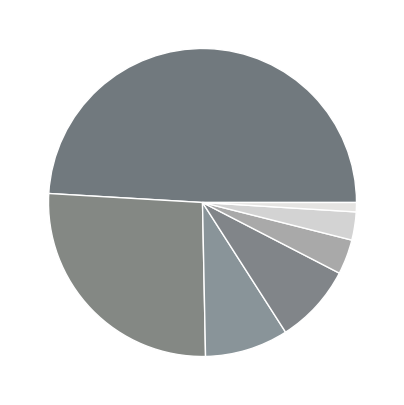

In [5]:
fig, ax = plt.subplots(figsize=(5,5))

monly_cells = number_of_patchseq_monly + number_of_ME_monly + number_of_EM_cells + number_of_fmost_cells
teonly_cells = number_of_patchseq_teonly
eonly_cells = number_of_patchseq_eonly + number_of_ME_eonly
tem_cells = number_of_patchseq_tem
tonly_cells = number_of_patchseq_tonly
meonly_cells = number_of_patchseq_meonly + number_of_ME_meonly
mtonly_cells = number_of_patchseq_tmonly 
y = np.array([monly_cells, teonly_cells, eonly_cells, tem_cells, tonly_cells, meonly_cells, mtonly_cells])
colors= ["#71797E", "#848884", "#899499", "#818589", "#A9A9A9", "#D3D3D3", "#E5E4E2"]
plt.pie(y, colors=colors)
plt.show() 
fig.savefig("/home/fahimehb/Local/new_codes/cplAE_MET/data/results/Figure/manuscript_figure_pieplot2.pdf")

### 1.3 Reference taxonomy and merging the t-types:
The following taxonomy was used and merged in order to obtain cell types at different resolution of taxonomy tree.

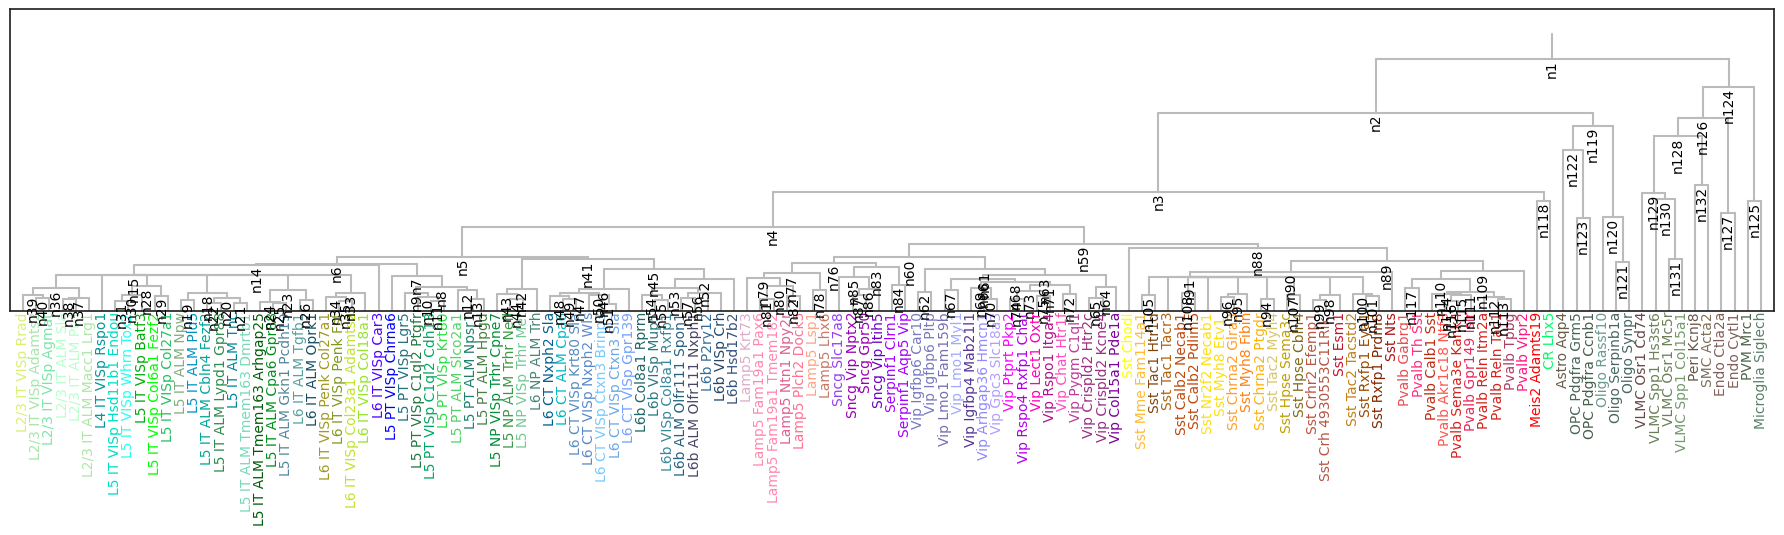

In [6]:
# This is the original taxonomy 
htree = HTree(htree_file="/home/fahimehb/Local/new_codes/cplAE_MET/tree_20180520.csv")
htree.plot(figsize=(18,4), fontsize=10)

44


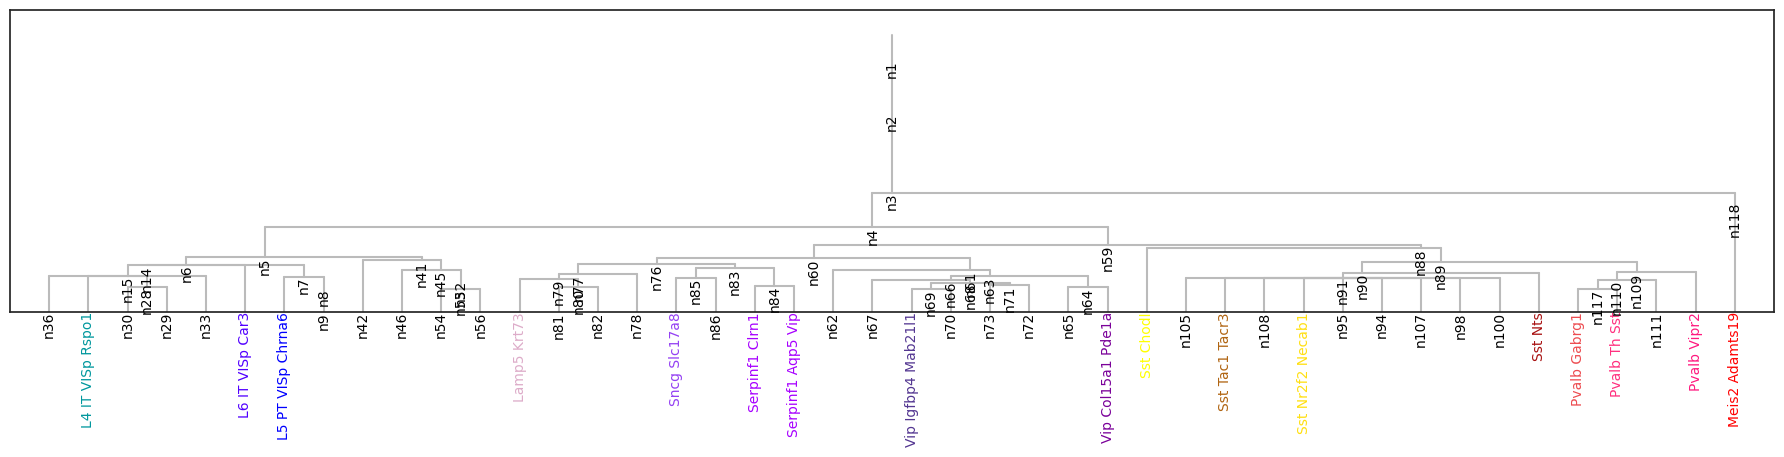

In [7]:
# and this is how it was merged to obtain different resolution:
# you can change 60 to any number you want to end up with some other resolution
# resolution at 60, resulted in 44 t-types. And this was used in the optimization 
# for classification of t-type
input_mat = "MET_M120x1_16k_28June23.mat"
input_data = sio.loadmat("/home/fahimehb/Remote-AI-root/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Patchseq-Exc/dat/" + input_mat)
is_t_1d = np.any(~np.isnan(input_data['T_dat']), axis=1)
cluster_label = input_data['cluster_label'][is_t_1d]
cluster_label = np.array([i.rstrip() for i in cluster_label])

merged_types, mtree, _  = get_merged_types(htree_file="/home/fahimehb/Local/new_codes/cplAE_MET/tree_20180520.csv", 
                                           cells_labels=cluster_label, 
                                           num_classes=60, 
                                           ref_leaf=cluster_label, 
                                           node="n1")

print(len(Counter(merged_types)))
mtree.plot(figsize=(18,4), fontsize=10)

## 2. Results 
### 2.1 Why using a coupled autoencoder:
First we would like to discuss why it makes sense to use a coupled autoencoder to analyze multiple modalities data. First we will present the results of a classifier which uses the m-features to classify the t-types. Classification acc is around 63%. However if we use a coupled autoencoder the results are greatly improved. See the following:

In [8]:
m_data = mat['M_dat']
t_data = mat['T_dat']
labels = mat['merged_cluster_label_at60']
is_m_1d = np.any(~np.isnan(m_data).reshape(m_data.shape[0], -1), axis=1)
is_t_1d = np.any(~np.isnan(t_data).reshape(t_data.shape[0], -1), axis=1)
is_tm_1d = np.logical_and(is_t_1d, is_m_1d)


features = m_data[is_tm_1d].reshape(m_data[is_tm_1d].shape[0], -1)
labels = np.array([i.rstrip() for i in labels[is_tm_1d]])
print("Number of cells before removing small clusters:", features.shape[0])

# so we are going to drop all the cells from the clusters that have less than 7 membs
drop_lables = []
for k,v in Counter(labels).items():
    if v < 7 :
        drop_lables.append(k)

mask = [True if i not in drop_lables else False for i in labels]
X_model1 = features[mask]
y = labels[mask]
print("Number of cells after removing small clusters:", X_model1.shape[0])
print("---------ttype classification---------------- ")
get_kfold_stratified_acc_per_fold(X_model1,y)

Number of cells before removing small clusters: 1557
Number of cells after removing small clusters: 1529
---------ttype classification---------------- 
Mean acc: 64.706 Number of types in test set 32
Mean acc: 62.745 Number of types in test set 32
Mean acc: 64.052 Number of types in test set 32
Mean acc: 64.052 Number of types in test set 32
Mean acc: 60.131 Number of types in test set 32
Mean acc: 62.745 Number of types in test set 32
Mean acc: 66.667 Number of types in test set 32
Mean acc: 66.013 Number of types in test set 31
Mean acc: 58.170 Number of types in test set 30
Mean acc: 63.158 Number of types in test set 31


(63.24389404884761, 2.424253336505082)

In the following, we made a coupled autoencoder and all the cells except EM cells were used in this autoencoder analysis. A bayesian optimization was used to find the optimal set of hyper-parameters. The Best results found was for trial 88 and in the following we show the umap of this trail for the m-autoencoder. Then a random forrest classifier was used on the 5d m-autoencoder latent representation (not the umap) and then the classification acc was reported which was around 83%.


(1529, 5) (1529,)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


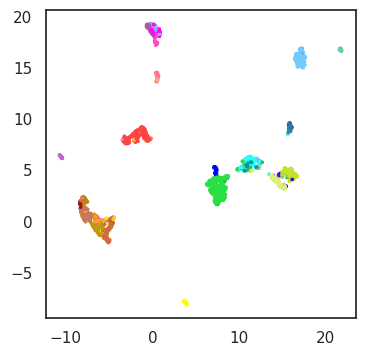

In [9]:
exp_name = "optuna_TEM_NO_EM_5ldim_2conv_10_10"
pkl_file = "Results_trial_88.pkl"
_, _, _, _, _, fig = calculate_and_plot_umap(exp_name=exp_name,
                                             pkl_file=pkl_file, 
                                             ttype_resolution="merged_cluster_label_at60", 
                                             autoencoder_arm_embedding_key="zm")

In [10]:
output = load_exp_output(exp_name="optuna_TEM_NO_EM_5ldim_2conv_10_10", pkl_file="Results_trial_88.pkl")
m_data = output['zm']
labels = output['merged_cluster_label_at60']
is_m_1d = output['is_t_1d']
is_t_1d = output['is_m_1d']
is_tm_1d = np.logical_and(is_t_1d, is_m_1d)


features = m_data[is_tm_1d].reshape(m_data[is_tm_1d].shape[0], -1)
labels = np.array([i.rstrip() for i in labels[is_tm_1d]])
print("Number of cells before removing small clusters:", features.shape[0])

# so we are going to drop all the cells from the clusters that have less than 7 membs
drop_lables = []
for k,v in Counter(labels).items():
    if v < 7 :
        drop_lables.append(k)

mask = [True if i not in drop_lables else False for i in labels]
X_model2 = features[mask]
y = labels[mask]
print("Number of cells after removing small clusters:", X_model2.shape[0])
print("---------ttype classification---------------- ")
get_kfold_stratified_acc_per_fold(X_model2,y)

Number of cells before removing small clusters: 1557
Number of cells after removing small clusters: 1529
---------ttype classification---------------- 
Mean acc: 84.314 Number of types in test set 32
Mean acc: 83.660 Number of types in test set 32
Mean acc: 79.085 Number of types in test set 32
Mean acc: 85.621 Number of types in test set 32
Mean acc: 82.353 Number of types in test set 32
Mean acc: 84.314 Number of types in test set 32
Mean acc: 81.699 Number of types in test set 32
Mean acc: 83.660 Number of types in test set 31
Mean acc: 82.353 Number of types in test set 30
Mean acc: 86.184 Number of types in test set 31


(83.32430340557275, 1.9528571543865858)

In order to see if this difference between ~60% and ~80% in classification accuracy using these two different techniques is real we used a 5x2 cross-validated paired t-test as the following:

In [11]:
X_model1 = X_model1 # in one model we used the m-features as the input
X_model2 = X_model2 # and in the other classifier we used the m-autoencoder latent representation as the input
y = y 

scoring = "accuracy"
estimator1 = RandomForestClassifier()
estimator2 = RandomForestClassifier()
random_seed = 1

cv1 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores1 = cross_val_score(estimator1, X_model1, y, scoring="accuracy", cv=cv1, n_jobs=1)
print('Random Forrest Mean Accuracy on Arbor_densities: %.3f (%.3f)' % (np.mean(scores1), np.std(scores1)))


cv2 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores2 = cross_val_score(estimator2, X_model2, y, scoring="accuracy", cv=cv2, n_jobs=1)
print('Random Forrest Mean Accuracy on cplAE_reps: %.3f (%.3f)' % (np.mean(scores2), np.std(scores2)))


########################################
# In the following we copied the original 5x2 paired t-test and modified it for our case
rng = np.random.RandomState(random_seed)

if isinstance(scoring, str):
    scorer = get_scorer(scoring)
else:
    scorer = scoring

variance_sum = 0.0
first_diff = None

def score_diff(X_tr_1, X_te_1, X_tr_2, X_te_2, y_train, y_test):
    estimator1.fit(X_tr_1, y_train)
    estimator2.fit(X_tr_2, y_train)
    est1_score = scorer(estimator1, X_te_1, y_test)
    est2_score = scorer(estimator2, X_te_2, y_test)
    score_diff = est1_score - est2_score
    return score_diff

for i in range(5):
    randint = rng.randint(low=0, high=32767)
    X_1_model1, X_2_model1, y_1, y_2 = train_test_split(X_model1, y, test_size=0.5, random_state=randint)
    X_1_model2, X_2_model2, y_1, y_2 = train_test_split(X_model2, y, test_size=0.5, random_state=randint)
    
    score_diff_1 = score_diff(X_1_model1, X_2_model1, X_1_model2, X_2_model2, y_1, y_2)
    score_diff_2 = score_diff(X_2_model1, X_1_model1, X_2_model2, X_1_model2, y_2, y_1)
    score_mean = (score_diff_1 + score_diff_2) / 2.0
    score_var = (score_diff_1 - score_mean) ** 2 + (score_diff_2 - score_mean) ** 2
    variance_sum += score_var
    if first_diff is None:
        first_diff = score_diff_1

numerator = first_diff
denominator = np.sqrt(1 / 5.0 * variance_sum)
t_stat = numerator / denominator

pvalue = stats.t.sf(np.abs(t_stat), 5) * 2.0
print(float(t_stat), float(pvalue))

if pvalue <= 0.05:
 print('Difference between mean performance is probably real')
else:
 print('Algorithms probably have the same performance')

Random Forrest Mean Accuracy on Arbor_densities: 0.628 (0.036)
Random Forrest Mean Accuracy on cplAE_reps: 0.837 (0.021)
-13.135862517111859 4.5647319273298024e-05
Difference between mean performance is probably real


## 2.2 Coupled vs separated autoencoders
In the following we will summarize the results of separate autoencoders (all the coupling terms are set to zero) vs coupled autoencoders analysis. In the case of coupled autoencoders, the hyper-parameters were found using bayesian optimization.

### 2.2.1 TEM coupled autoencoder analysis. Number of cells: 16,703, M arbor density image shape: 120 × 1, and latent dimension: 3

In [12]:
study = load_study("TEM_16k_3d_M120x1_2conv_10_10")
study.best_trial

[I 2023-08-18 13:52:08,973] Using an existing study with name 'TEM_16k_3d_M120x1_2conv_10_10' instead of creating a new one.


sqlite:////home/fahimehb/Local/new_codes/cplAE_MET/data/results/TEM_16k_3d_M120x1_2conv_10_10/TEM_16k_3d_M120x1_2conv_10_10.db


FrozenTrial(number=353, values=[46.34146341463415], datetime_start=datetime.datetime(2023, 7, 3, 3, 0, 3, 624331), datetime_complete=datetime.datetime(2023, 7, 3, 8, 24, 58, 390918), params={'alpha_E': 0.920145084388561, 'alpha_M': 0.04526157931996336, 'alpha_ME': -1.6017479025931094, 'lambda_tune_E_T': -1.8014222070452204, 'lambda_tune_ME_E': 1.349031637367409, 'lambda_tune_ME_M': 3.0977541189700486, 'lambda_tune_ME_T': -1.222055403444346, 'lambda_tune_M_T': -5.07842857953105, 'lambda_tune_T_E': 4.503961945982062, 'lambda_tune_T_M': 1.3633399700895144, 'lambda_tune_T_ME': 2.384042468594444}, distributions={'alpha_E': FloatDistribution(high=6.0, log=False, low=-2.0, step=None), 'alpha_M': FloatDistribution(high=6.0, log=False, low=-2.0, step=None), 'alpha_ME': FloatDistribution(high=6.0, log=False, low=-2.0, step=None), 'lambda_tune_E_T': FloatDistribution(high=2.0, log=False, low=-2.0, step=None), 'lambda_tune_ME_E': FloatDistribution(high=6.0, log=False, low=1.0, step=None), 'lambda_

In [13]:
print("Total number of trials:", len(study.trials))

Total number of trials: 1219


In [14]:
# plot all the hyperparametrs that were explored by bayesian optimization
# note that these are log values and the exponential of these values was used as the hyper-parameters
plot_parallel_coordinate(study)

In [15]:
study.best_params

{'alpha_E': 0.920145084388561,
 'alpha_M': 0.04526157931996336,
 'alpha_ME': -1.6017479025931094,
 'lambda_tune_E_T': -1.8014222070452204,
 'lambda_tune_ME_E': 1.349031637367409,
 'lambda_tune_ME_M': 3.0977541189700486,
 'lambda_tune_ME_T': -1.222055403444346,
 'lambda_tune_M_T': -5.07842857953105,
 'lambda_tune_T_E': 4.503961945982062,
 'lambda_tune_T_M': 1.3633399700895144,
 'lambda_tune_T_ME': 2.384042468594444}

The best trial was trail 353, from that trial we took all the hyper-params and ran ~14 other coupled autoencoder with the same hyper-param values to see how stable is the results.

In [16]:
output = {}
output['T_E_M_separate_AE'] = load_exp_output(exp_name="Tonly_Eonly_Monly_16k", pkl_file="trial_0_checkpoint_epoch_8000.pkl")
output['T_E_M_separate_AE']['platform'] = np.array(["EM" if i==1 else "patchseq" for i in output['T_E_M_separate_AE']['platform']])
for pk in [ # All of the following trails except the last one are near the optimal hyper-param 
           'trial_1204_checkpoint_epoch_9000.pkl',
           'trial_1205_checkpoint_epoch_9000.pkl',
           'trial_1206_checkpoint_epoch_9000.pkl',
           'trial_1207_checkpoint_epoch_9000.pkl',
           'trial_1208_checkpoint_epoch_9000.pkl',
           'trial_1209_checkpoint_epoch_6000.pkl',
           'trial_1210_checkpoint_epoch_9000.pkl', 
           'trial_1211_checkpoint_epoch_9000.pkl', 
           'trial_1212_checkpoint_epoch_9000.pkl', 
           'trial_1213_checkpoint_epoch_9000.pkl',
           'trial_1214_checkpoint_epoch_9000.pkl',
           'trial_1215_checkpoint_epoch_9000.pkl',
           'trial_1216_checkpoint_epoch_9000.pkl',
           'trial_1217_checkpoint_epoch_9000.pkl',
           'trial_1218_checkpoint_epoch_9000.pkl',
           # this is a random trail for the plotting purposes
           'trial_14_checkpoint_epoch_2500.pkl']:
    key = pk.split("_checkpoint")[0]
    output[key] = load_exp_output(exp_name="TEM_16k_3d_M120x1_2conv_10_10", pkl_file=pk)
    output[key]['platform'] = np.array(["EM" if i==1 else "patchseq" for i in output[key]['platform']])

In [17]:
def get_merging_classification_accuracy(trial, T_labels, for_validation_cells=False): 
    '''
    trial: the output mat file of the coupled autoencoder
    T_labels: the transcriptomic label for each cell
    for_validation_cells: if this is true then the classification accuracy is computed for the 
    validation cells of the coupled autoencoders. The set of the cells that were never used during
    the training of the model. If this is False the the classifier is trained on all 90% of the cells
    and the results are reported in the remaining 10% of the cells.
    '''
    
    train_ind = trial['train_ind']
    val_ind = trial['val_ind']
    masks = get_all_1d_mask(trial)
    is_t_1d = masks['is_t_1d']
    is_train_1d = np.array([False for i in (range(len(is_t_1d)))])
    is_train_1d[train_ind] = True
    is_test_1d = np.array([False for i in (range(len(is_t_1d)))])
    is_test_1d[val_ind] = True 
    is_t_train_1d = np.logical_and(is_t_1d, is_train_1d)
    is_t_test_1d = np.logical_and(is_t_1d, is_test_1d)
    t_train_ind = np.where(is_t_train_1d)
    t_test_ind = np.where(is_t_test_1d)
    

    df = pd.DataFrame(columns=["t_class_acc", "e_class_acc", "me_class_acc", "m_class_acc", "t_classes"])
    for i, c in enumerate(['merged_cluster_label_at40', 
                           'merged_cluster_label_at50', 
                           'merged_cluster_label_at60', 
                           'merged_cluster_label_at70', 
                           'merged_cluster_label_at80',
                           'merged_cluster_label_at90']):
        
        y = T_labels[c]
        zt = trial['zt']
        ze = trial['ze']
        zm = trial['zm']
        zme_paired = trial['zme_paired']

        if for_validation_cells:
            t_cpl_score, t_classes, clf= run_QDA(zt, y, 
                                                 train_test_ids={'train': t_train_ind, 'val': t_test_ind})
            te_cpl_score = clf.score(ze[val_ind], y[val_ind]) * 100
            tm_cpl_score = clf.score(zm[val_ind], y[val_ind]) * 100
            met_cpl_score = clf.score(zme_paired[val_ind], y[val_ind]) * 100

        else:    
            t_cpl_score, t_classes, clf= run_QDA(zt[masks['is_t_1d']], y[masks['is_t_1d']])
            te_cpl_score = clf.score(ze[masks['is_te_1d']], y[masks['is_te_1d']]) * 100
            tm_cpl_score = clf.score(zm[masks['is_tm_1d']], y[masks['is_tm_1d']]) * 100
            met_cpl_score = clf.score(zme_paired[masks['is_met_1d']], y[masks['is_met_1d']]) * 100

        df.loc[i, 't_class_acc'] = t_cpl_score
        df.loc[i, 'e_class_acc'] = te_cpl_score
        df.loc[i, 'me_class_acc'] = met_cpl_score
        df.loc[i, 'm_class_acc'] = tm_cpl_score
        df.loc[i, 't_classes'] = t_classes
    return df

In [18]:
T_labels={}
T_labels['merged_cluster_label_at40'] = output['trial_1218']['merged_cluster_label_at40']
T_labels['merged_cluster_label_at50'] = output['trial_1218']['merged_cluster_label_at50']
T_labels['merged_cluster_label_at60'] = output['trial_1218']['merged_cluster_label_at60']
T_labels['merged_cluster_label_at70'] = output['trial_1218']['merged_cluster_label_at70']
T_labels['merged_cluster_label_at80'] = output['trial_1218']['merged_cluster_label_at80']
T_labels['merged_cluster_label_at90'] = output['trial_1218']['merged_cluster_label_at90']


In [19]:
classification_accuracy_results = {}
for k in output.keys():
    classification_accuracy_results[k] = get_merging_classification_accuracy(output[k], T_labels)

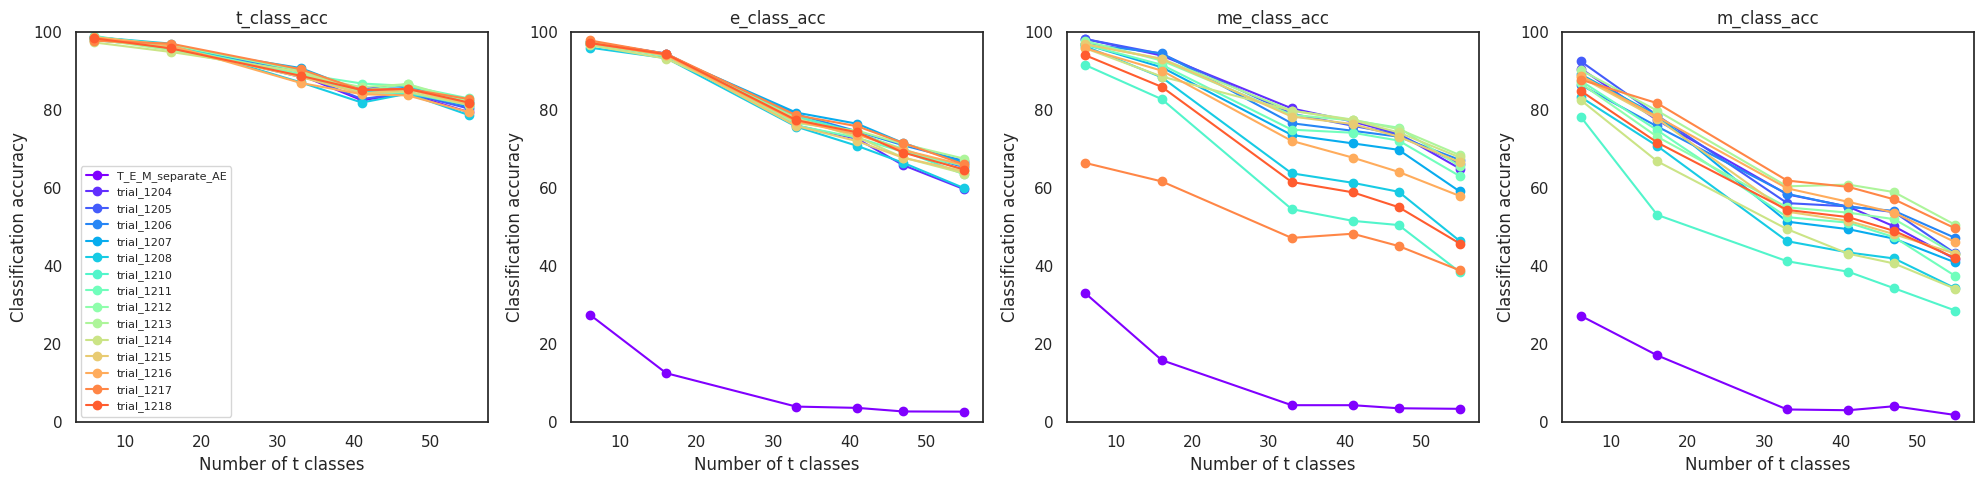

In [20]:
# Define the columns to plot and the corresponding titles
columns = ['t_class_acc', 'e_class_acc', 'me_class_acc', 'm_class_acc']
titles = ['t_class_acc', 'e_class_acc', 'me_class_acc', 'm_class_acc']

# Create a custom color map for the keys using 'rainbow'
color_map = plt.cm.get_cmap('rainbow')
num_keys = len(classification_accuracy_results)

fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))

# Iterate over each column and plot the data for each key
for i, column in enumerate(columns):
    ax = axes[i]  # Get the current subplot
    ax.set_title(titles[i])  # Set the title for the current subplot

    # Iterate over each key and plot the data
    for j, (key, df) in enumerate(classification_accuracy_results.items()):
        if key not in ["trial_14", "trial_1209"]:
            # Get a unique color for each key from the 'rainbow' color map
            color = color_map(j / num_keys)

            # Plot the data for the current key and column
            ax.plot(df['t_classes'], df[column], label=key, color=color, marker='o')

    if i == 0:
        ax.legend(fontsize=8)  # Display the legend for the current subplot
    ax.set_xlabel("Number of t classes")
    ax.set_ylabel("Classification accuracy")
    ax.set_ylim(0, 100)

plt.tight_layout()  # Adjust the layout to prevent overlap

# Use mplcursors to display annotations on hover
cursors = [mplcursors.cursor(ax, hover=True) for ax in axes]

plt.show()

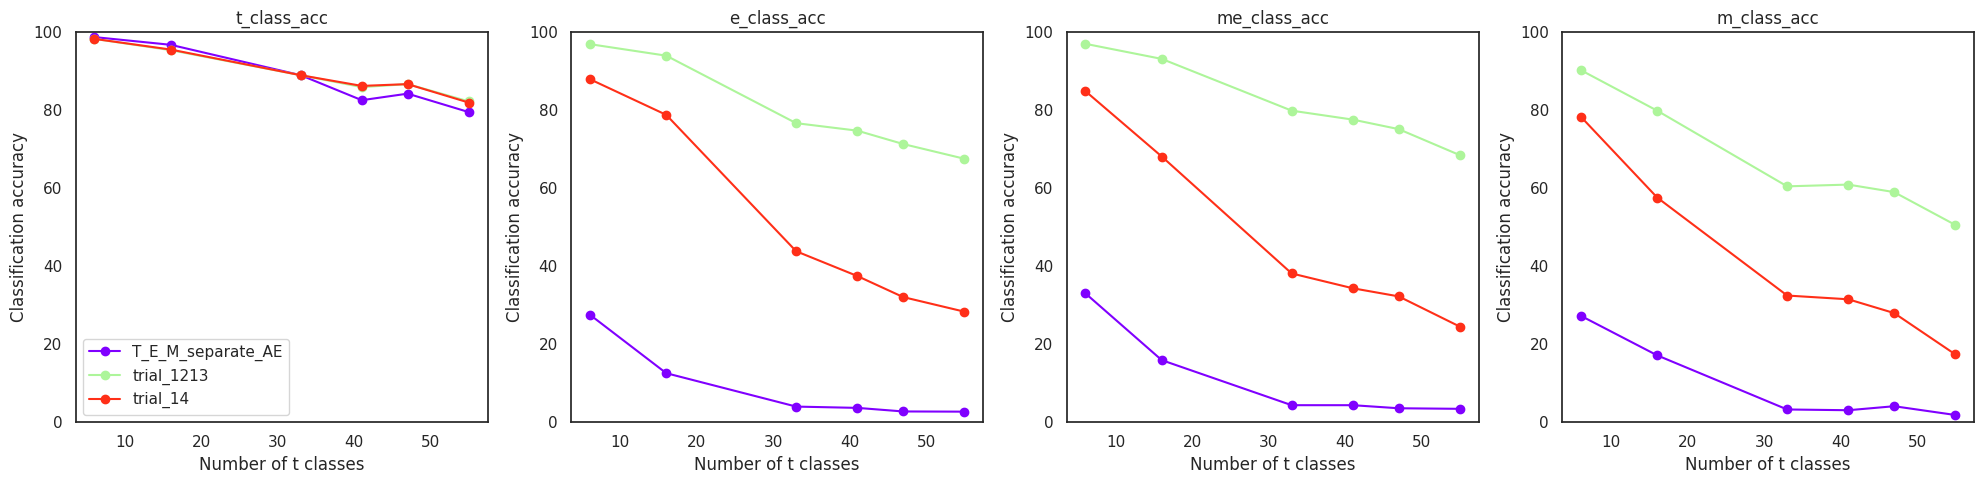

In [21]:
# Define the columns to plot and the corresponding titles
columns = ['t_class_acc', 'e_class_acc', 'me_class_acc', 'm_class_acc']
titles = ['t_class_acc', 'e_class_acc', 'me_class_acc', 'm_class_acc']

# Create a custom color map for the keys using 'rainbow'
color_map = plt.cm.get_cmap('rainbow')
num_keys = len(classification_accuracy_results)

fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))

# Iterate over each column and plot the data for each key
for i, column in enumerate(columns):
    ax = axes[i]  # Get the current subplot
    ax.set_title(titles[i])  # Set the title for the current subplot

    # Iterate over each key and plot the data
    for j, (key, df) in enumerate(classification_accuracy_results.items()):
        if key in ["T_E_M_separate_AE", "trial_14", "trial_1213"]:
            # Get a unique color for each key from the 'rainbow' color map
            color = color_map(j / num_keys)

            # Plot the data for the current key and column
            ax.plot(df['t_classes'], df[column], label=key, color=color, marker='o')

    if i == 0:
        ax.legend()  # Display the legend for the current subplot
    ax.set_xlabel("Number of t classes")
    ax.set_ylabel("Classification accuracy")
    ax.set_ylim(0, 100)

plt.tight_layout()  # Adjust the layout to prevent overlap

# Use mplcursors to display annotations on hover
cursors = [mplcursors.cursor(ax, hover=True) for ax in axes]

plt.show()

======================================== Separate autoencoders ==========================================


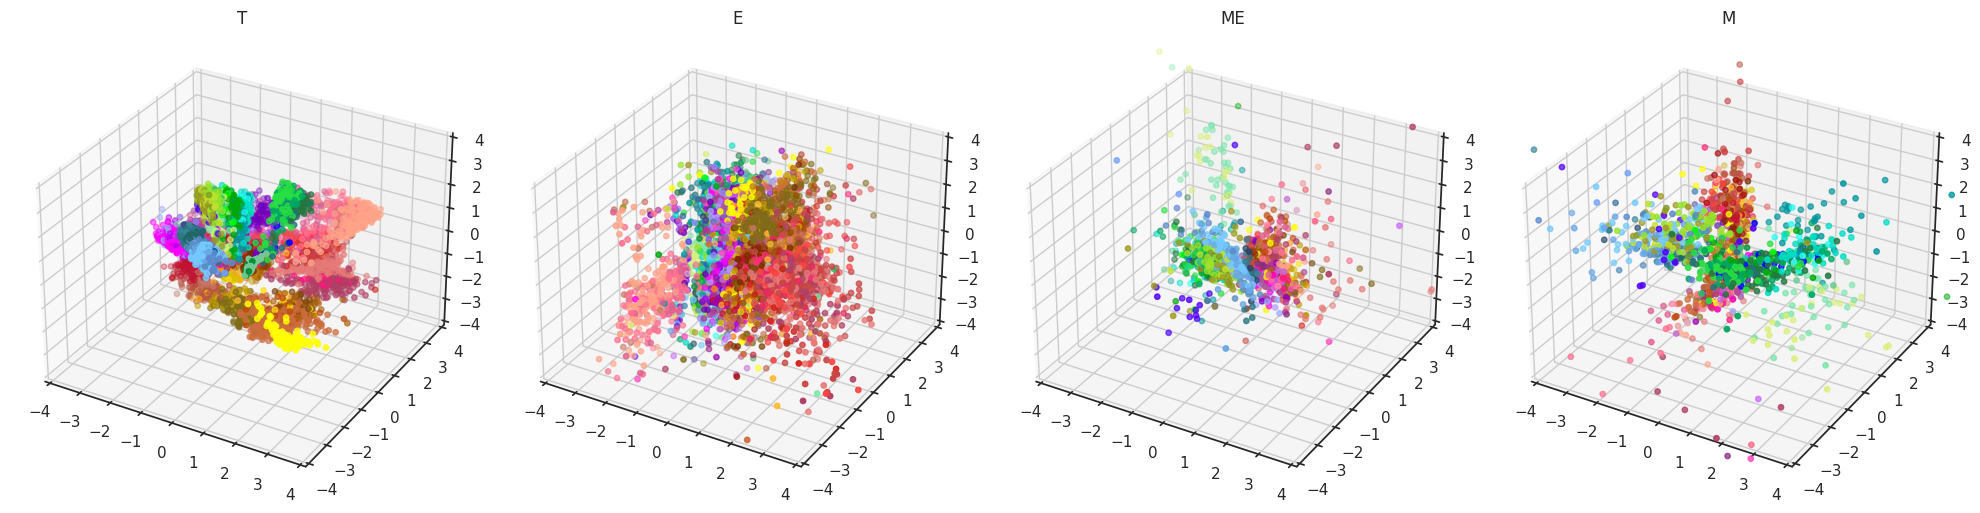

===================== Trial 14, Coupled autoencoder with NOT optimal hyper-parameters ====================


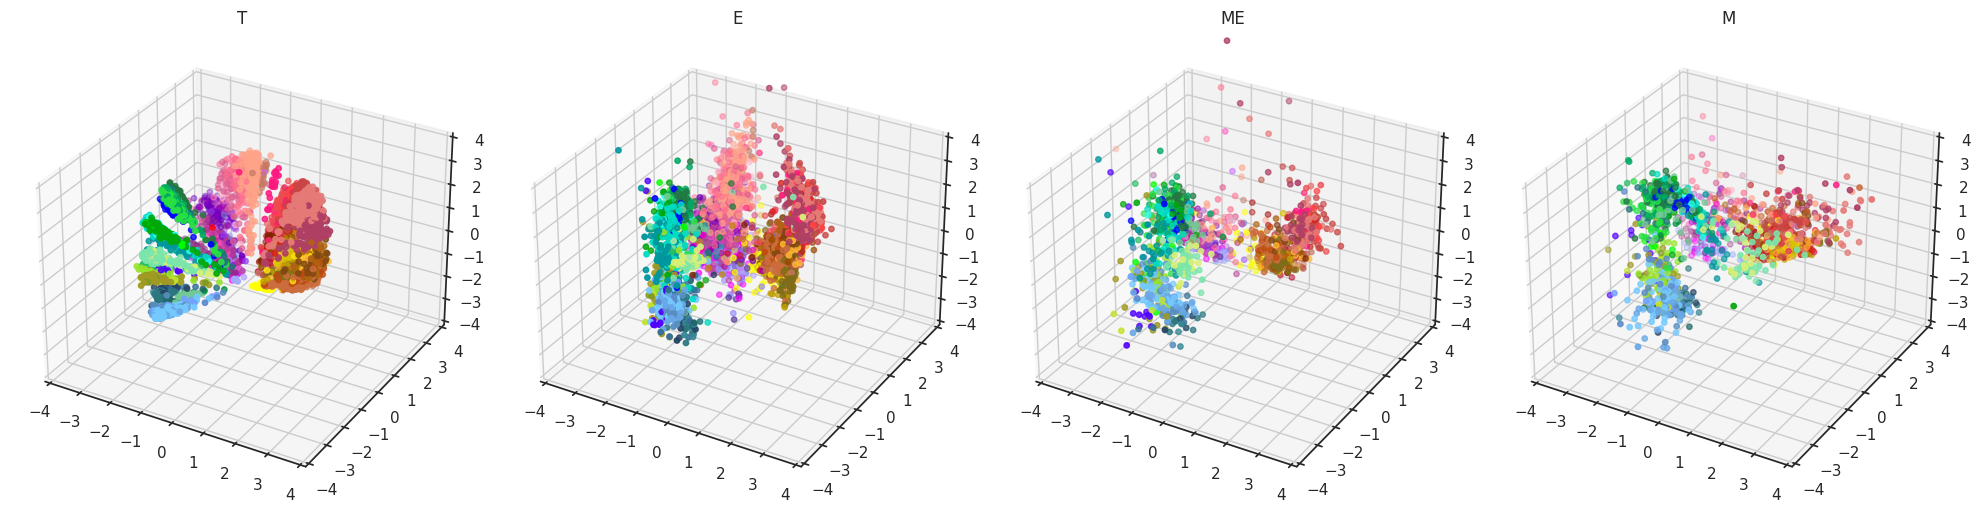

===================== Trial 1213, Coupled autoencoder with optimal hyper-parameters ======================


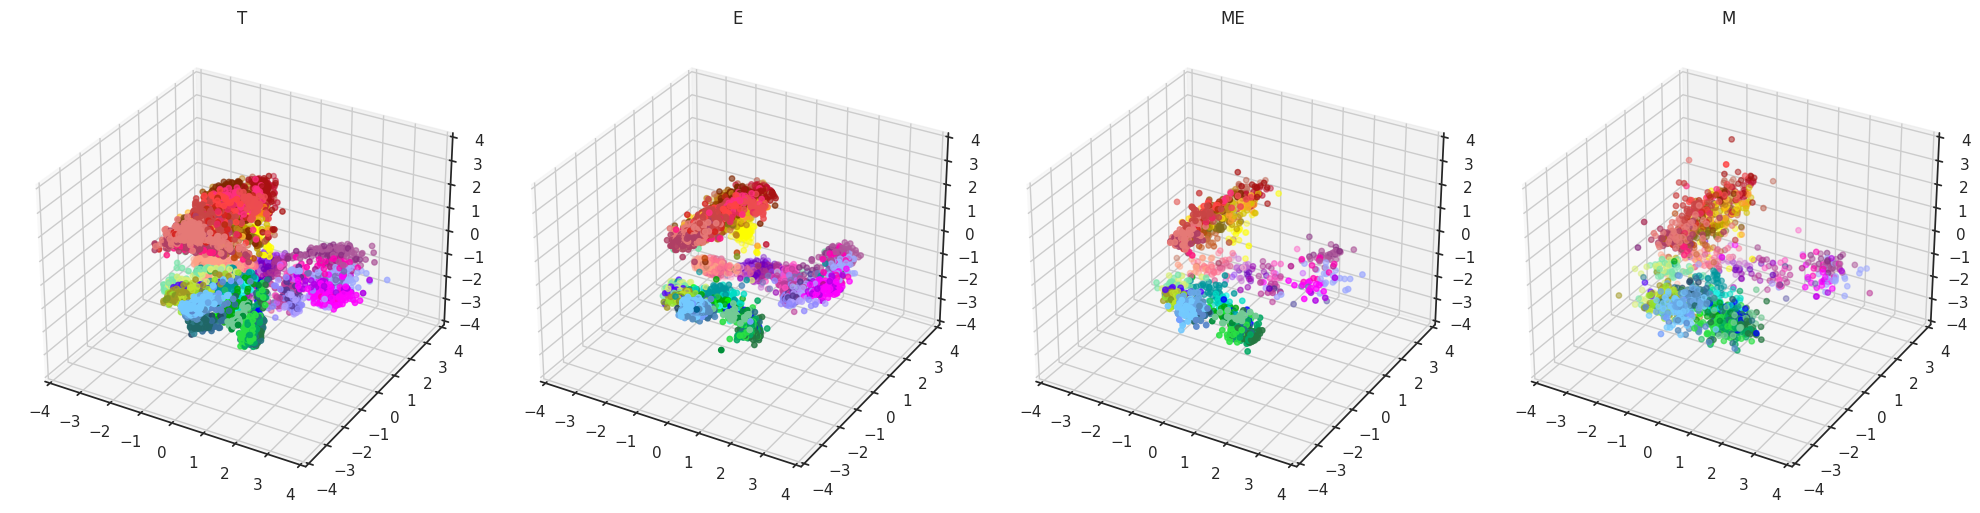

In [22]:
lim = (-4,4)
print ("======================================== Separate autoencoders ==========================================")
out = load_exp_output(exp_name="Tonly_Eonly_Monly_16k", pkl_file="trial_0_checkpoint_epoch_8000.pkl")
fig = plot_z_3d(out, xlim=lim, ylim=lim, zlim=lim)
print("===================== Trial 14, Coupled autoencoder with NOT optimal hyper-parameters ====================")
out = load_exp_output(exp_name="TEM_16k_3d_M120x1_2conv_10_10", pkl_file="trial_14_checkpoint_epoch_2500.pkl")
fig = plot_z_3d(out, xlim=lim, ylim=lim, zlim=lim)
print("===================== Trial 1213, Coupled autoencoder with optimal hyper-parameters ======================")
out = load_exp_output(exp_name="TEM_16k_3d_M120x1_2conv_10_10", pkl_file="trial_1213_checkpoint_epoch_9000.pkl")
fig = plot_z_3d(out, xlim=lim, ylim=lim, zlim=lim)

Optimal trail (1213)

![test](./trial_1213_checkpoint_epoch_9000.gif)

In [23]:
study = load_study("TEM_16k_3d_M120x1_2conv_10_10")

trial_numbers = [14, 1204, 1205, 1206, 1207, 1208, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218]  # Replace with your desired trial numbers

# List to store the extracted parameter values
extracted_params = []

# Iterate over the trial numbers
for trial_number in trial_numbers:
    # Get the Optuna trial corresponding to the trial number
    trial = study.trials[trial_number]

    # Extract the parameter values from the trial
    params = trial.params
    params['trial_number'] = trial_number  # Include trial number in the extracted parameters
    extracted_params.append(params)

# Create a dataframe from the extracted parameter values
df = pd.DataFrame(extracted_params)
columns_to_convert = df.columns.drop("trial_number")
df[columns_to_convert] = df[columns_to_convert].apply(np.exp)
df

[I 2023-08-18 13:52:36,433] Using an existing study with name 'TEM_16k_3d_M120x1_2conv_10_10' instead of creating a new one.


sqlite:////home/fahimehb/Local/new_codes/cplAE_MET/data/results/TEM_16k_3d_M120x1_2conv_10_10/TEM_16k_3d_M120x1_2conv_10_10.db


alpha_E    alpha_M  alpha_ME  lambda_tune_E_T  lambda_tune_ME_E  \
0   0.237026  33.703988  4.918340         2.666682         29.200281   
1   2.511801   1.047072  0.201690         0.165133          3.854483   
2   2.511799   1.046030  0.201509         0.165089          3.853572   
3   2.511747   1.046039  0.201695         0.165134          3.853574   
4   2.511786   1.046032  0.201694         0.165133          3.857425   
5   2.510211   1.046031  0.201694         0.165134          3.857424   
6   2.510229   1.047071  0.201494         0.165134          3.853614   
7   2.511800   1.046035  0.201694         0.165133          3.853599   
8   2.511798   1.047073  0.201695         0.165130          3.857425   
9   2.511800   1.046029  0.201694         0.165133          3.857425   
10  2.511789   1.046033  0.201694         0.165133          3.853580   
11  2.511795   1.046029  0.201495         0.164969          3.853580   
12  2.509314   1.046033  0.201695         0.165134          3.853571   
13  2.511800   1.046030  0.201695         0.165134          3.857423   
14  2.509291   1.046028  0.201693         0.165134          3.853592   

    lambda_tune_ME_M  lambda_tune_ME_T  lambda_tune_M_T  lambda_tune_T_E  \
0          58.456745          0.007662         0.140401         3.432359   
1          22.131481          0.294346         0.006228        90.287755   
2          22.131650          0.294346         0.006227        90.287802   
3          22.131545          0.294347         0.006226        90.287862   
4          22.153494          0.294346         0.006232        90.287614   
5          22.131476          0.294346         0.006226        90.287612   
6          22.153527          0.294350         0.006232        90.377597   
7          22.153423          0.294347         0.006226        90.287641   
8          22.153572          0.294347         0.006226        90.287678   
9          22.153305          0.294346         0.006232        90.287660   
10         22.153569          0.294474         0.006226        90.287660   
11         22.153482          0.294346         0.006226        90.377842   
12         22.131537          0.294347         0.006226        90.287749   
13         22.131567          0.294346         0.006226        90.375129   
14         22.131485          0.294352         0.006231        90.287667   

    lambda_tune_T_M  lambda_tune_T_ME  trial_number  
0        102.209954         17.375746            14  
1          3.907901         10.859054          1204  
2          3.911808         10.859057          1205  
3          3.907912         10.858667          1206  
4          3.910370         10.859047          1207  
5          3.907959         10.858654          1208  
6          3.911808         10.858979          1210  
7          3.907907         10.858897          1211  
8          3.911809         10.859049          1212  
9          3.907900         10.859010          1213  
10         3.911809         10.859056          1214  
11         3.907914         10.859061          1215  
12         3.909396         10.848229          1216  
13         3.911809         10.848244          1217  
14         3.911809         10.848384          1218

In [24]:
classification_accuracy_results['trial_1213']

t_class_acc e_class_acc me_class_acc m_class_acc t_classes
0   82.290076   67.583939    68.507891   50.610148        55
1   86.717557   71.356871     75.17934   59.023764        47
2   85.954198   74.783662    77.618364   60.950546        41
3   89.007634   76.704742    79.913917   60.500963        33
4   95.426829   94.011769    93.185079   79.897238        16
5   98.323171    96.97127    97.058824   90.301863         6

4


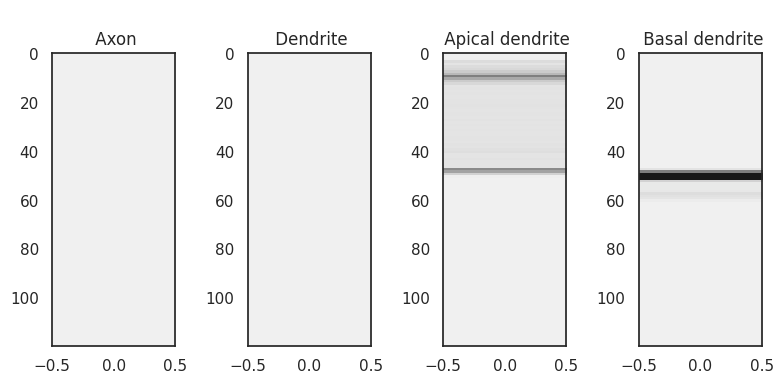

4


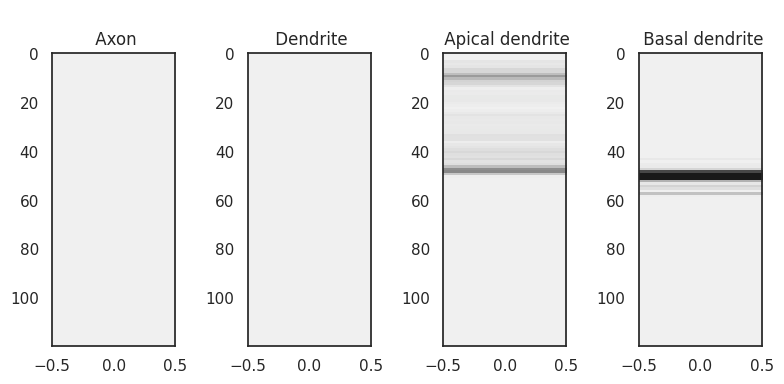

In [25]:
def plot_m_example_t_type(trial ,t_type):
    masks = get_all_1d_mask(trial)
    is_select_t = trial['cluster_label'] == t_type
    is_select_tm = np.logical_and(is_select_t, masks['is_m_1d'])
    max_cell_number = np.sum(is_select_tm)
    cell = random.randint(0, max_cell_number-1)
    fig1 = plot_m(trial['XM'][is_select_tm][cell,...])
    fig2 = plot_m(trial['XrM'][is_select_tm][cell,...])
    return fig1, fig2

fig1, fig2 = plot_m_example_t_type(output['trial_1213'], "L4 IT VISp Rspo1")

### 2.2.2 TEM coupled autoencoder analysis. Number of cells: 16,703, M arbor density image shape: 120 × 1, and latent dimension: 5

We performed The same analysis as above, however we changed the latent dimension to 5 to increase the t-type classification acc.

(1529, 5) (1529,)


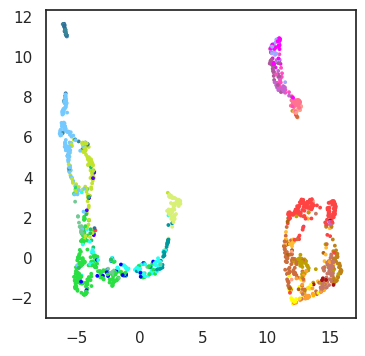

Mean acc: 64.706 Number of types in test set 32
Mean acc: 66.667 Number of types in test set 32
Mean acc: 70.588 Number of types in test set 32
Mean acc: 69.935 Number of types in test set 32
Mean acc: 64.052 Number of types in test set 32
Mean acc: 66.013 Number of types in test set 32
Mean acc: 75.163 Number of types in test set 32
Mean acc: 67.974 Number of types in test set 31
Mean acc: 66.667 Number of types in test set 30
Mean acc: 66.447 Number of types in test set 31
67.82120743034054 3.1270887494488266


In [26]:
exp_name = "TEM_16k_5d_M120x1_2conv_10_10"
pkl_file = "Results_trial_194.pkl"
X, X_ids, y, umap_coor, updated_colors, fig = calculate_and_plot_umap(exp_name=exp_name,
                                                                      pkl_file=pkl_file,
                                                                      ttype_resolution="merged_cluster_label_at60", 
                                                                      autoencoder_arm_embedding_key="zm")

mean_acc, std_acc = get_kfold_stratified_acc_per_fold(umap_coor, y)
print(mean_acc, std_acc)

As it is clear, the classification acc even with latent dimension of 5 is not large. As we reported before (look at the beggining of the notebook), the classification acc of a coupled autoencoder was around 80%. However for that results the shape of m-data was not 120x1 as it is here. It was instead 120x4. So We decided to make another dataset with the m-data that have 120x4 shape. With this new shape, we had to do the QC for the EM cells again. There is another notebook which explains this step. This resulted in a new dataset with ~13800 cells. See the following for the results.

### 2.2.2 TEM coupled autoencoder analysis. Number of cells: 13,812, M arbor density image shape: 120 × 4, and latent dimension: 5

(1529, 5) (1529,)


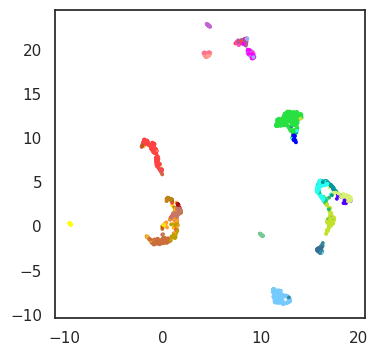

Mean acc: 79.739 Number of types in test set 32
Mean acc: 81.046 Number of types in test set 32
Mean acc: 81.046 Number of types in test set 32
Mean acc: 83.007 Number of types in test set 32
Mean acc: 78.431 Number of types in test set 32
Mean acc: 79.739 Number of types in test set 32
Mean acc: 83.007 Number of types in test set 32
Mean acc: 83.660 Number of types in test set 31
Mean acc: 79.085 Number of types in test set 30
Mean acc: 79.605 Number of types in test set 31
80.83634330925352 1.739481502049393


In [27]:
exp_name = "TEM_13k_5d_M120x4_2conv_10_10"
pkl_file = "Results_trial_650.pkl"
X_6k, X_6k_ids, y_6k, umap_coor, updated_colors, fig = calculate_and_plot_umap(exp_name=exp_name,
                                                                               pkl_file=pkl_file, 
                                                                               ttype_resolution="merged_cluster_label_at60", 
                                                                               autoencoder_arm_embedding_key="zm")
mean_acc, std_acc = get_kfold_stratified_acc_per_fold(umap_coor, y_6k)
print(mean_acc, std_acc)

So in all of these analysis, still the loaction of the EM cells is not satisfactory and the results are not stable

In [28]:
from cplAE_MET.models.classification_functions import get_small_types_mask
output = load_exp_output(exp_name, pkl_file)
is_t_1d = output['is_t_1d']
is_m_1d = output['is_m_1d']
is_tm_1d = np.logical_and(is_t_1d, is_m_1d)
tm_cells = np.where(is_tm_1d)[0]

X = output['zm'][is_tm_1d]
y = output['merged_cluster_label_at60'][is_tm_1d]
small_types_mask = get_small_types_mask(y, 5)
small_types_cells = np.where(small_types_mask)[0]

X = X[small_types_mask]
y = y[small_types_mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size=0.1, random_state=0)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Mean acc for all the data: %.3f' % (accuracy_score(y_test, y_pred) * 100), len(Counter(y_test)))


train_ind = output['train_ind']
val_ind = output['val_ind']
train_ind = [i for i in output['train_ind'] if i in tm_cells]
val_ind = [i for i in output['val_ind'] if i in tm_cells]
# train_ind = [i for i in train_ind if i in small_types_cells]
# val_ind = [i for i in val_ind if i in small_types_cells]

X = output['zm']
y = output['merged_cluster_label_at60']

X_train, y_train = X[train_ind], y[train_ind]
X_test, y_test = X[val_ind], y[val_ind]


model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Mean acc for validation cells: %.3f' % (accuracy_score(y_test, y_pred) * 100), len(Counter(y_test)))

Mean acc for all the data: 76.774 34
Mean acc for validation cells: 43.902 27
